Perform object detection using any standard object detector such as YOLO and visualzie the
result on the dash cam video i.e. raw video.

In [47]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests
from google.colab.patches import cv2_imshow
import numpy as np


In [48]:
def detectObject(img):

  image = img

  # print(image)
  # print(image.size)

  model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
  image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

  inputs = image_processor(images=image, return_tensors="pt")
  outputs = model(**inputs)

  # model predicts bounding boxes and corresponding COCO classes
  logits = outputs.logits
  bboxes = outputs.pred_boxes


  # print results
  target_sizes = torch.tensor([image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

  detect_list = []
  box_coords = []
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      detect_list.append(
          f"Detected {model.config.id2label[label.item()]} with confidence "
          f"{round(score.item(), 3)} at location {box}"
      )
      print(box)
      box_coords.append(box)

  return detect_list,box_coords



In [49]:
import cv2
import os
def extract_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)

    # Creating the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    frames = []
    objects = []
    boxes = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Saving every 30th frame (including the first frame)
        if frame_count % 30 == 0:
            print(len(frames))
            # frame = cv2.resize(frame, (1000, 1000))
            x = Image.fromarray(frame)
            obj, b = detectObject(x)

            frames.append(frame)
            objects.append(obj)
            boxes.append(b)

        # Skipping 29 frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count + 30)
        frame_count += 30

    cap.release()

    return frames, objects, boxes



In [50]:

video_path = '/content/car_video.mp4'
output_folder = '/content/objframes/'

frames, objects, boxes = extract_frames(video_path, output_folder)


print(f"Number of frames: {len(frames)}")

0
1
2
3
[411.28, 280.8, 490.8, 345.58]
4
5
[358.39, 264.11, 470.92, 359.09]
6
7
[87.33, 204.88, 350.41, 408.33]
8
9
10
11
12
13
14
[627.36, 228.13, 696.04, 358.45]
[513.89, 255.53, 525.86, 280.25]
[506.82, 254.78, 519.1, 280.5]
15
[498.44, 250.1, 511.53, 278.73]
[501.09, 247.96, 514.4, 279.28]
[549.21, 240.74, 591.58, 315.47]
[553.27, 286.13, 582.82, 325.17]
[554.9, 275.2, 588.65, 324.95]
[509.48, 250.56, 523.16, 279.5]
16
[493.85, 253.56, 505.37, 281.51]
[486.88, 252.8, 499.14, 281.89]
[528.32, 248.52, 558.57, 300.67]
17
[107.4, 222.24, 130.02, 258.66]
[518.91, 249.1, 536.07, 292.2]
[457.1, 251.01, 470.3, 283.11]
[100.05, 222.22, 122.3, 258.18]
[463.53, 251.33, 477.66, 283.4]
[47.25, 212.2, 67.58, 248.87]
[520.55, 247.44, 541.65, 294.21]
[474.21, 252.91, 487.48, 283.75]
18
[511.37, 247.22, 529.94, 288.5]
[133.54, 182.67, 356.85, 307.72]
[509.69, 248.59, 526.51, 288.75]
19
[331.08, 255.03, 394.22, 297.27]
[0.58, 148.68, 273.88, 325.73]
[498.4, 247.91, 514.02, 281.62]
[503.6, 239.93, 52

In [51]:
print(f"Number of objects: {len(objects)}")

Number of objects: 81


In [52]:
homographies = np.load('/content/new_homographies.npy')

In [53]:
def markObject(index):
  red = [0,0,255]
  img = frames[index]
  for box in boxes[index]:
    new_x = (box[0]+box[2])/2
    new_y = box[3]
    new_x = int(new_x)
    new_y = int(new_y)
    img = cv2.circle(img, (new_x,new_y), 5, red, -1)
  cv2_imshow(img)
  return img

In [54]:
def generateTopView(index):
  img = markObject(index)
  # img = frames[index]
  img = cv2.resize(img, (1000, 1000))
  height, width = img.shape[:2]
  img_top_view = cv2.warpPerspective(img, homographies[index], (width, height))
  cv2_imshow(img_top_view)

Then overlay detection locations (i.e. mid-point of
base of bounding box) on top-view/satellite view. Object detector will give you a list of bounding
boxes, note the mid-point of the base of bounding box and project it on to the top view/satellite
view using the computed homography sequence (current view to first image, first image to
satellite image).

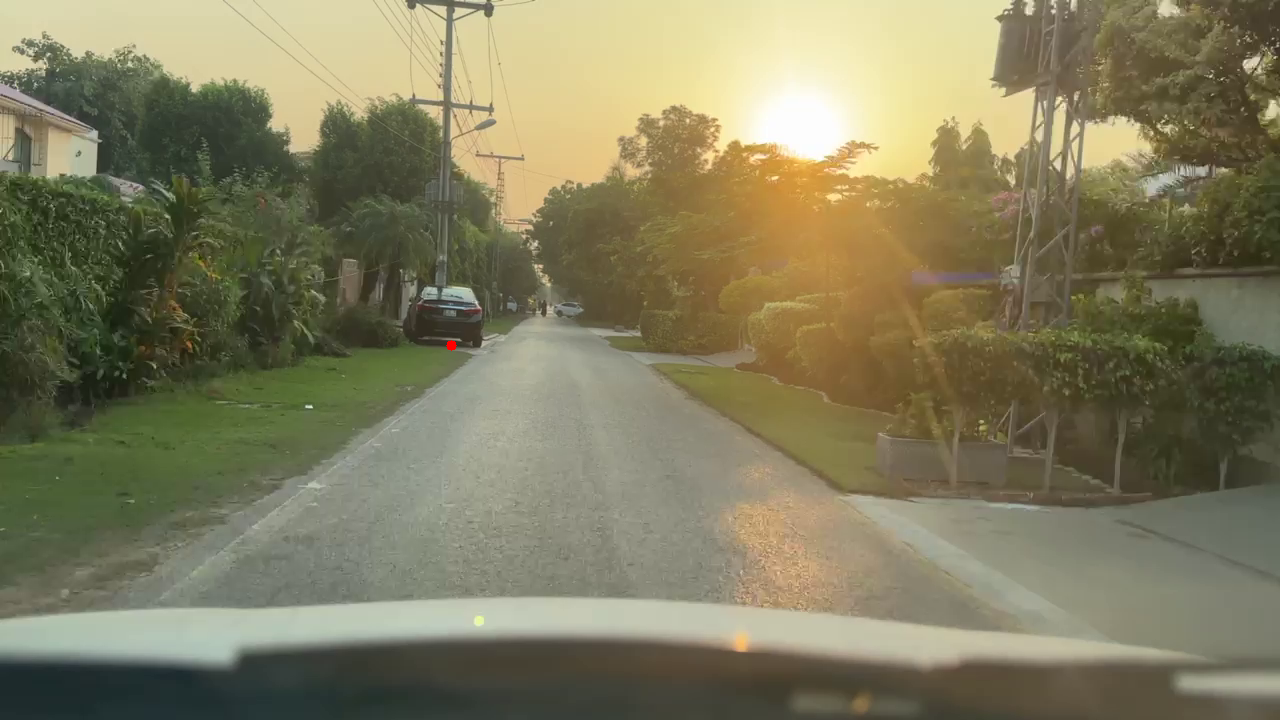

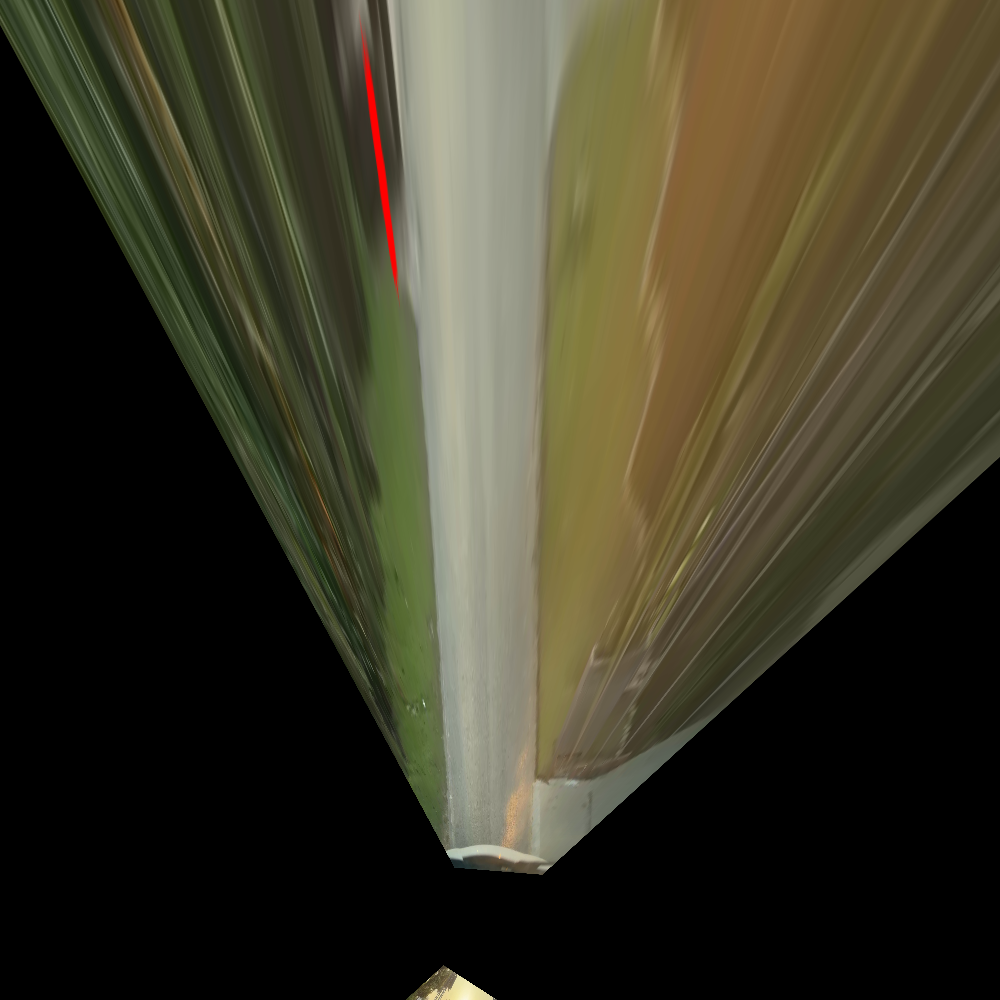

In [55]:
generateTopView(3)